In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.io import fits
from astropy.table import Table, vstack
from ParamVAEapply import ParamVAEapply
from BandPassVAE import BandPassVAE
from SpectraVAE import SpectraVAE
from ParamVAE import ParamVAE
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import numpy.ma as ma
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from utils import Sampling
from astropy.stats import sigma_clip


def load_paramvaeapply(path: str, weight_file: str, input_dim: int, latent_dim: int, beta: float) -> ParamVAEapply:
    """
    Loads weights and builds a ParamVAEapply model from a saved epoch weight file.

    Parameters:
        weight_file (str): Path to the weights file (.h5).
        input_dim (int): Dimensionality of the input data.
        latent_dim (int): Latent space dimensionality.
        beta (float): Beta value for VAE loss.

    Returns:
        ParamVAEapply: A ready-to-use model with loaded weights.
    """
    # Build required submodels
    
    spvae_wf = os.path.join(os.path.join(path, 'SpectraVAE'), weight_file)
    bpvae_wf = os.path.join(os.path.join(path, 'BandPassVAE'), weight_file)
    parvae_wf = os.path.join(os.path.join(path, 'ParamVAE'), weight_file)
    print(spvae_wf, bpvae_wf, parvae_wf)
    spvae = SpectraVAE(100, latent_dim, beta=beta)
    spvae.compile() #optimizer=keras.optimizers.Adam())
    spvae(tf.zeros((1, 100)))  # Force model building
    spvae.load_weights(spvae_wf)

    bpvae = BandPassVAE(input_dim, latent_dim, spvae, beta=beta)
    bpvae.compile()#optimizer=keras.optimizers.Adam())
    bpvae(tf.zeros((1, input_dim)))  # Force model building
    bpvae.load_weights(bpvae_wf)

    # Attach ParamVAE
    parvae = ParamVAE(100, latent_dim, spvae, beta=beta, n_param=4)
    parvae.compile()#optimizer=keras.optimizers.Adam())
    parvae(tf.zeros((1, 100)))  # Force model building
    parvae.load_weights(parvae_wf)

    return ParamVAEapply(input_dim, latent_dim, bpvae, parvae, beta=beta), parvae, bpvae, spvae


latent_dim = 64
beta = 1e-3
epoch = 1
n_param = 4
input_dim = 5
epoch = 150

chunk_size = 100_000      # user-defined chunk size
n_smpl = 10               # number of model samples per chunk

id_run = '20251010162214'
weight_path = "/data/kirg/MMVAE/cigale/" + id_run + "/"
save_path = os.path.join(weight_path, 'epochs/')
plot_output_path = os.path.join(weight_path, 'cornerplots_train_' + id_run)


tr_smpl = os.path.join(weight_path, 'train_dataset_cigale_tmpl.fits')

weight_file = f"weights_epoch_{epoch:02d}.weights.h5"
parvaeapply, parvae, bpvae, spvae = load_paramvaeapply(
    save_path, weight_file, input_dim, latent_dim, beta
)



t = Table.read(tr_smpl)

inp_spec = t['Spec']
inp_sed = t['SED']
inp_par = t['Param']

2025-11-23 10:04:39.367930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 10:04:39.375484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763888679.384151   95114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763888679.386760   95114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763888679.393548   95114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

/data/kirg/MMVAE/cigale/20251010162214/epochs/SpectraVAE/weights_epoch_150.weights.h5 /data/kirg/MMVAE/cigale/20251010162214/epochs/BandPassVAE/weights_epoch_150.weights.h5 /data/kirg/MMVAE/cigale/20251010162214/epochs/ParamVAE/weights_epoch_150.weights.h5


2025-11-23 10:04:40.372039: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-11-23 10:04:40.372054: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-23 10:04:40.372056: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: apcastrodeep2
2025-11-23 10:04:40.372058: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: apcastrodeep2
2025-11-23 10:04:40.372106: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 535.274.2
2025-11-23 10:04:40.372114: I external/local_xla/xla/stream_execu

In [6]:
import numpy as np
from astropy.table import Table
from astropy.stats import sigma_clip

# --- загрузка данных ---
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')

z_min = 0.02
z_max = 1.4

# --- фильтрация ---
mask = (
    (t_hsc_['z'] > z_min) & (t_hsc_['z'] < z_max) &
    (t_hsc_['g_kronflux_mag'] > 0) &
    (t_hsc_['r_kronflux_mag'] > 0) &
    (t_hsc_['i_kronflux_mag'] > 0) &
    (t_hsc_['z_kronflux_mag'] > 0) &
    (t_hsc_['y_kronflux_mag'] > 0) &
    (t_hsc_['zwarn'] == 0)
)

t_hsc = t_hsc_[mask]

# --- подготовка входов ---
hsc_int = []
hsz_z   = []

for r in t_hsc:
    mags = np.array([
        r['g_kronflux_mag'],
        r['r_kronflux_mag'],
        r['i_kronflux_mag'],
        r['z_kronflux_mag'],
        r['y_kronflux_mag']
    ])
    bandfl = 10 ** (-0.4 * mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

hsc_int = np.array(hsc_int)
hsz_z   = np.array(hsz_z)
n = len(hsc_int)

'''

# --- параметры ---
Nbin = 15
bins = np.linspace(0.0, 1.4, Nbin + 1)

# --- таблица результатов ---
res_table = Table(names=('n_smpl', 'meandz'), dtype=('i4', 'f8'))

# --- основной цикл по n_smpl ---
for n_smpl in range(1, 51):

    # многократное применение модели
    s_all = []
    for i in range(n_smpl):
        s = parvaeapply(hsc_int.reshape(n, 5))
        s_all.append(s)

    s_all = np.array(s_all)
    z_infr_all = s_all[:, :, 0]       # shape: (n_smpl, n_objects)
    p = hsz_z                         # истинные красные смещения

    # минимальное отклонение по каждому объекту
    idx = np.abs(z_infr_all - p).argmin(axis=0)
    z_infr_closest = z_infr_all[idx, np.arange(n)]

    z_mean = np.nanmean(z_infr_all, axis=0)

    plx = z_mean
    ply = p - z_infr_closest

    # бинning по z_mean
    indices = np.digitize(plx, bins)

    std_arr = []
    zmean_arr = []
    n_arr = []

    for i in range(1, Nbin + 1):
        bin_mask = indices == i
        if np.any(bin_mask):

            # сигма-клип
            cat_outl = np.abs(ply) > 0.3
            clipped = sigma_clip(ply[bin_mask & ~cat_outl],
                                 sigma=2.5, maxiters=10, cenfunc='mean')

            good = clipped.data[~clipped.mask]
            if len(good) == 0:
                continue

            mean_val = np.mean(good)
            std_val  = np.std(good)

            std_arr.append(std_val)
            zmean_arr.append(np.mean(plx[bin_mask]))
            n_arr.append(np.sum(bin_mask))

    std_arr   = np.array(std_arr)
    zmean_arr = np.array(zmean_arr)
    n_arr     = np.array(n_arr)

    # итоговое meandz
    meandz = np.nansum(n_arr * std_arr / (1 + zmean_arr)) / np.nansum(n_arr)

    # запись в таблицу
    res_table.add_row((n_smpl, meandz))

    print(f"n_smpl={n_smpl} → meandz={meandz:.6f}")

# --- сохранение результата ---
res_table.write('meandz_results.csv', overwrite=True)
'''

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=1 → meandz=0.059293
n_smpl=2 → meandz=0.046160


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=3 → meandz=0.039612


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=4 → meandz=0.035262


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=5 → meandz=0.031512


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=6 → meandz=0.029103


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=7 → meandz=0.026342


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=8 → meandz=0.024733


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=9 → meandz=0.023175


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=10 → meandz=0.021692


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=11 → meandz=0.020421


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=12 → meandz=0.019292


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=13 → meandz=0.018377


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=14 → meandz=0.017541


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=15 → meandz=0.016968


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=16 → meandz=0.016180


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=17 → meandz=0.015609


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=18 → meandz=0.014933


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=19 → meandz=0.014604


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=20 → meandz=0.014122


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=21 → meandz=0.013601


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=22 → meandz=0.013163


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=23 → meandz=0.012727


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=24 → meandz=0.012429


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=25 → meandz=0.012133


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=26 → meandz=0.011974


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=27 → meandz=0.011734


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=28 → meandz=0.011419


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=29 → meandz=0.011246


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=30 → meandz=0.010952


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=31 → meandz=0.010771


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=32 → meandz=0.010481


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=33 → meandz=0.010326


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=34 → meandz=0.010200


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=35 → meandz=0.010136


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=36 → meandz=0.009931


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=37 → meandz=0.009662


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=38 → meandz=0.009564


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=39 → meandz=0.009389


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=40 → meandz=0.009255


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=41 → meandz=0.009095


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=42 → meandz=0.009048


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=43 → meandz=0.008839


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=44 → meandz=0.008745


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=45 → meandz=0.008627


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=46 → meandz=0.008594


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=47 → meandz=0.008472


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=48 → meandz=0.008396


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=49 → meandz=0.008261


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(158663, 5))
  warnings.warn(msg)


n_smpl=50 → meandz=0.008151


In [14]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

def analytical_sigma(mu, sigma, k):
    """
    Return sigma(Y) for vector k using independent quad calls.
    """
    k = np.atleast_1d(k)
    res = np.zeros_like(k, dtype=float)

    # pdf
    def fX(x):
        return norm.pdf((x - mu) / sigma) / sigma

    # CDF of |X|
    def F_abs(z):
        return norm.cdf((z - mu)/sigma) - norm.cdf((-z - mu)/sigma)

    # integrands
    def integrand_EY(z, k):
        return z * (fX(z) - fX(-z)) * (1 - F_abs(z))**(k - 1)

    def integrand_EY2(z, k):
        return z**2 * (fX(z) + fX(-z)) * (1 - F_abs(z))**(k - 1)

    for i, ki in enumerate(k):
        EY  = ki * quad(integrand_EY,  0, np.inf, args=(ki,), limit=200)[0]
        EY2 = ki * quad(integrand_EY2, 0, np.inf, args=(ki,), limit=200)[0]
        res[i] = np.sqrt(EY2 - EY**2)

    return res

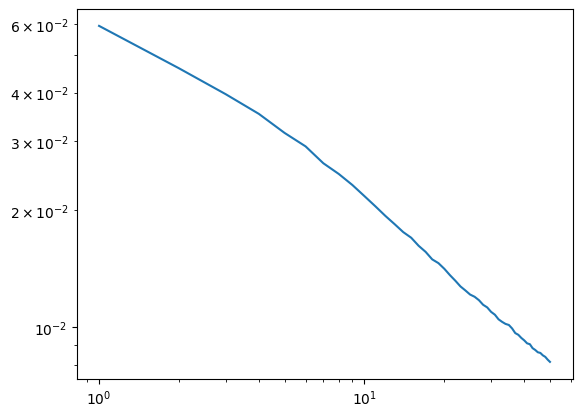

In [15]:
from astropy.table import Table
import matplotlib.pyplot as plt


t = Table.read('meandz_results.csv')


plt.plot(t['n_smpl'], t['meandz'])
plt.xscale('log')
plt.yscale('log')
plt.show()

<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_95114/2332472848.py:39: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$<\Delta z / (1 + z)>$")
/tmp/ipykernel_95114/776770620.py:29: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  EY2 = ki * quad(integrand_EY2, 0, np.inf, args=(ki,), limit=200)[0]


Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
mu      0.09017     -inf      inf 0.0006933     True     None     None
sigma   0.05659    1e-06      inf 0.000649     True     None     None
None


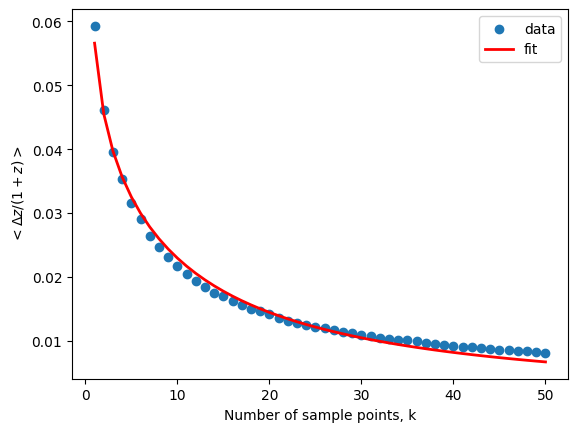

In [22]:
from lmfit import Minimizer, Parameters

# --- residual function for Minimizer ---
def residual(params, k, data):
    mu = params['mu']
    sigma = params['sigma']
    model_vals = analytical_sigma(mu, sigma, k)
    return model_vals - data


# Load your table:
# t = Table.read('meandz_results.csv')
k_data = np.array(t['n_smpl'], dtype=float)
sigma_data = np.array(t['meandz'], dtype=float)

# --- initial parameters ---
params = Parameters()
params.add('mu', value=0.0)
params.add('sigma', value=0.05, min=1e-6)   # sigma must stay positive

# --- perform the fit ---
minimizer = Minimizer(residual, params, fcn_args=(k_data, sigma_data))
result = minimizer.minimize()

# print results
print(result.params.pretty_print())



best_mu = result.params['mu'].value
best_sigma = result.params['sigma'].value



<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_95114/2181822865.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$<\Delta z / (1 + z)>$")


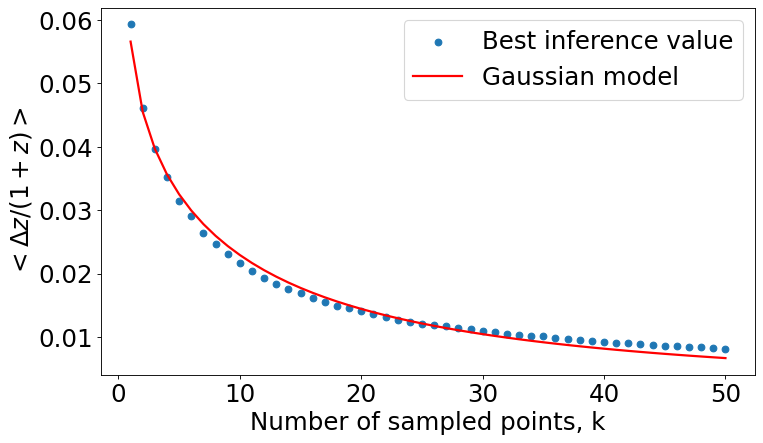

In [27]:
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(10, 6), dpi=80)

plt.scatter(k_data, sigma_data, label="Best inference value")
plt.plot(k_data,
         analytical_sigma(best_mu, best_sigma, k_data),
         'r-', lw=2, label="Gaussian model")

plt.xlabel("Number of sampled points, k")
plt.ylabel("$<\Delta z / (1 + z)>$")
plt.legend()
plt.tight_layout()
plt.savefig('dz_k_smpl.pdf')
plt.show()